<a href="https://colab.research.google.com/github/maryraha/natural-language-processing/blob/master/Twitter_PulseChecker_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import lots of stuff
import sys
import os
import re
import tweepy
from tweepy import OAuthHandler
from textblob import TextBlob

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import clear_output
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

In [0]:
# install Flair
!pip install flair

clear_output()

In [0]:
# import Flair stuff
from flair.data import Sentence
from flair.models import SequenceTagger

tagger = SequenceTagger.load('ner')

clear_output()

In [0]:
#import Flair Classifier
from flair.models import TextClassifier

classifier = TextClassifier.load('en-sentiment')

clear_output()

In [0]:
TWITTER_KEY= "Mz35QVYUA772uqocvWqzBAhtv"
TWITTER_SECRET_KEY= "PplQ9tg59z91IXYr2OvoZZMx2kplGwOV0Umsc1dVg9rAAmbqk2"
# Authenticate
auth = tweepy.AppAuthHandler(TWITTER_KEY, TWITTER_SECRET_KEY)

api = tweepy.API(auth, wait_on_rate_limit=True,
				   wait_on_rate_limit_notify=True)

if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)

In [15]:
#@title Twitter Search API Inputs
#@markdown ### Enter Search Query:
searchQuery = 'COVID19' #@param {type:"string"}
#@markdown ### Enter Max Tweets To Scrape:
#@markdown #### The Twitter API Rate Limit (currently) is 45,000 tweets every 15 minutes.
maxTweets = 1000 #@param {type:"slider", min:0, max:45000, step:100}
Filter_Retweets = True #@param {type:"boolean"}

tweetsPerQry = 100  # this is the max the API permits
tweet_lst = []

if Filter_Retweets:
  searchQuery = searchQuery + ' -filter:retweets'  # to exclude retweets

# If results from a specific ID onwards are reqd, set since_id to that ID.
# else default to no lower limit, go as far back as API allows
sinceId = None

# If results only below a specific ID are, set max_id to that ID.
# else default to no upper limit, start from the most recent tweet matching the search query.
max_id = -10000000000

tweetCount = 0
print("Downloading max {0} tweets".format(maxTweets))
while tweetCount < maxTweets:
    try:
        if (max_id <= 0):
            if (not sinceId):
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry, lang="en")
            else:
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                        lang="en", since_id=sinceId)
        else:
            if (not sinceId):
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                        lang="en", max_id=str(max_id - 1))
            else:
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                        lang="en", max_id=str(max_id - 1),
                                        since_id=sinceId)
        if not new_tweets:
            print("No more tweets found")
            break
        for tweet in new_tweets:
          if hasattr(tweet, 'reply_count'):
            reply_count = tweet.reply_count
          else:
            reply_count = 0
          if hasattr(tweet, 'retweeted'):
            retweeted = tweet.retweeted
          else:
            retweeted = "NA"
            
          # fixup search query to get topic
          topic = searchQuery[:searchQuery.find('-')].capitalize().strip()
          
          # fixup date
          tweetDate = tweet.created_at.date()
          
          tweet_lst.append([tweetDate, topic, 
                      tweet.id, tweet.user.screen_name, tweet.user.name, tweet.text, tweet.favorite_count, 
                      reply_count, tweet.retweet_count, retweeted])

        tweetCount += len(new_tweets)
        print("Downloaded {0} tweets".format(tweetCount))
        max_id = new_tweets[-1].id
    except tweepy.TweepError as e:
        # Just exit if any error
        print("some error : " + str(e))
        break

clear_output()
print("Downloaded {0} tweets".format(tweetCount))

Downloaded 1000 tweets


In [18]:
pd.set_option('display.max_colwidth', -1)

# load it into a pandas dataframe
tweet_df = pd.DataFrame(tweet_lst, columns=['tweet_dt', 'topic', 'id', 'username', 'name', 'tweet', 'like_count', 'reply_count', 'retweet_count', 'retweeted'])
tweet_df.to_csv('tweets.csv')
tweet_df.head()

,tweet_dt,topic,id,username,name,tweet,like_count,reply_count,retweet_count,retweeted
0,2020-03-30,Covid19,1244490551929569284,malhotra_five,Aarti,@BPCLimited All of the above #StayHomeStaySafe #COVID19#Precautions,0,0,0,False
1,2020-03-30,Covid19,1244490548922245121,NobelProse,E. Rosalie,"No, you’re not crazy: why outbreaks are on the rise https://t.co/quAJEhZ0G6 #covid19 #coronavirusupdates… https://t.co/N4vCEUq94N",0,0,0,False
2,2020-03-30,Covid19,1244490548871823368,foodformzansi,Food For Mzansi,"The #21DayLockdownSA to stop the spread of #Covid19 is underway, and many are experiencing both uncertainty and bor… https://t.co/5e4dXvcwgV",0,0,0,False
3,2020-03-30,Covid19,1244490548536172545,easwaranrutnam,Easwaran 'Easy' Rutnam,The number of patients confirmed to have contracted the coronavirus in Sri Lanka rose to 120 today. #Srilanka #lka… https://t.co/28A1uY7XTU,0,0,0,False
4,2020-03-30,Covid19,1244490548179656706,yoncabulutmd,Yonca Bulut M.D.,"Can’t agree more Annabelle @destmauricemd 👏👏 is doing a fantastic job, she is our #hero and still responding to mi… https://t.co/iXNWXxD3SO",0,0,0,False


In [0]:
# predict NER
nerlst = []

for index, row in tqdm(tweet_df.iterrows(), total=tweet_df.shape[0]):
  cleanedTweet = row['tweet'].replace("#", "")
  sentence = Sentence(cleanedTweet, use_tokenizer=True)
  
  # predict NER tags
  tagger.predict(sentence)

  # get ner
  ners = sentence.to_dict(tag_type='ner')['entities']
  
  # predict sentiment
  classifier.predict(sentence)
  
  label = sentence.labels[0]
  response = {'result': label.value, 'polarity':label.score}
  
  # get hashtags
  hashtags = re.findall(r'#\w+', row['tweet'])
  if len(hashtags) >= 1:
    for hashtag in hashtags:
      ners.append({ 'type': 'Hashtag', 'text': hashtag })
  
  for ner in ners:
    adj_polarity = response['polarity']
    if response['result'] == 'NEGATIVE':
      adj_polarity = response['polarity'] * -1
    nerlst.append([ row['tweet_dt'], row['topic'], row['id'], row['username'], 
                   row['name'], row['tweet'], ner['type'], ner['text'], response['result'], 
                   response['polarity'], adj_polarity, row['like_count'], row['reply_count'], 
                  row['retweet_count'] ])

clear_output()

In [30]:
df_ner = pd.DataFrame(nerlst, columns=['tweet_dt', 'topic', 'id', 'username', 'name', 'tweet', 'tag_type', 'tag', 'sentiment', 'polarity', 
                                       'adj_polarity','like_count', 'reply_count', 'retweet_count'])
df_ner.head()

,tweet_dt,topic,id,username,name,tweet,tag_type,tag,sentiment,polarity,adj_polarity,like_count,reply_count,retweet_count
0,2020-03-30,Covid19,1244490551929569284,malhotra_five,Aarti,@BPCLimited All of the above #StayHomeStaySafe #COVID19#Precautions,Hashtag,#StayHomeStaySafe,POSITIVE,0.968759,0.968759,0,0,0
1,2020-03-30,Covid19,1244490551929569284,malhotra_five,Aarti,@BPCLimited All of the above #StayHomeStaySafe #COVID19#Precautions,Hashtag,#COVID19,POSITIVE,0.968759,0.968759,0,0,0
2,2020-03-30,Covid19,1244490551929569284,malhotra_five,Aarti,@BPCLimited All of the above #StayHomeStaySafe #COVID19#Precautions,Hashtag,#Precautions,POSITIVE,0.968759,0.968759,0,0,0
3,2020-03-30,Covid19,1244490548922245121,NobelProse,E. Rosalie,"No, you’re not crazy: why outbreaks are on the rise https://t.co/quAJEhZ0G6 #covid19 #coronavirusupdates… https://t.co/N4vCEUq94N",Hashtag,#covid19,NEGATIVE,0.999984,-0.999984,0,0,0
4,2020-03-30,Covid19,1244490548922245121,NobelProse,E. Rosalie,"No, you’re not crazy: why outbreaks are on the rise https://t.co/quAJEhZ0G6 #covid19 #coronavirusupdates… https://t.co/N4vCEUq94N",Hashtag,#coronavirusupdates,NEGATIVE,0.999984,-0.999984,0,0,0


In [36]:
ner_groups = df_ner.groupby(['tag', 'tag_type']).agg({'tag': "count", 'adj_polarity': "mean",
                                                     'like_count': 'sum', 'reply_count': 'sum',
                                                     'retweet_count': 'sum'})
ner_groups = ner_groups.rename(columns={
    "tag": "Frequency",
    "adj_polarity": "Avg_Polarity",
    "like_count": "Total_Likes",
    "reply_count": "Total_Replies",
    "retweet_count": "Total_Retweets"
})
ner_groups = ner_groups.sort_values(['Frequency'], ascending=False)
ner_groups = ner_groups.reset_index()
ner_groups.head()

,tag,tag_type,Frequency,Avg_Polarity,Total_Likes,Total_Replies,Total_Retweets
0,#COVID19,Hashtag,266,-0.736730,353,0,96
1,#covid19,Hashtag,58,-0.788382,12,0,4
2,#coronavirus,Hashtag,46,-0.682978,18,0,6
3,#Covid19,Hashtag,41,-0.710837,74,0,15
4,COVID19,MISC,22,-0.710680,11,0,3


In [37]:
ner_groups['Sentiment'] = np.where(ner_groups['Avg_Polarity']>=0, 'POSITIVE', 'NEGATIVE')
ner_groups.head()

,tag,tag_type,Frequency,Avg_Polarity,Total_Likes,Total_Replies,Total_Retweets,Sentiment
0,#COVID19,Hashtag,266,-0.736730,353,0,96,NEGATIVE
1,#covid19,Hashtag,58,-0.788382,12,0,4,NEGATIVE
2,#coronavirus,Hashtag,46,-0.682978,18,0,6,NEGATIVE
3,#Covid19,Hashtag,41,-0.710837,74,0,15,NEGATIVE
4,COVID19,MISC,22,-0.710680,11,0,3,NEGATIVE


Text(0.5, 0, '')

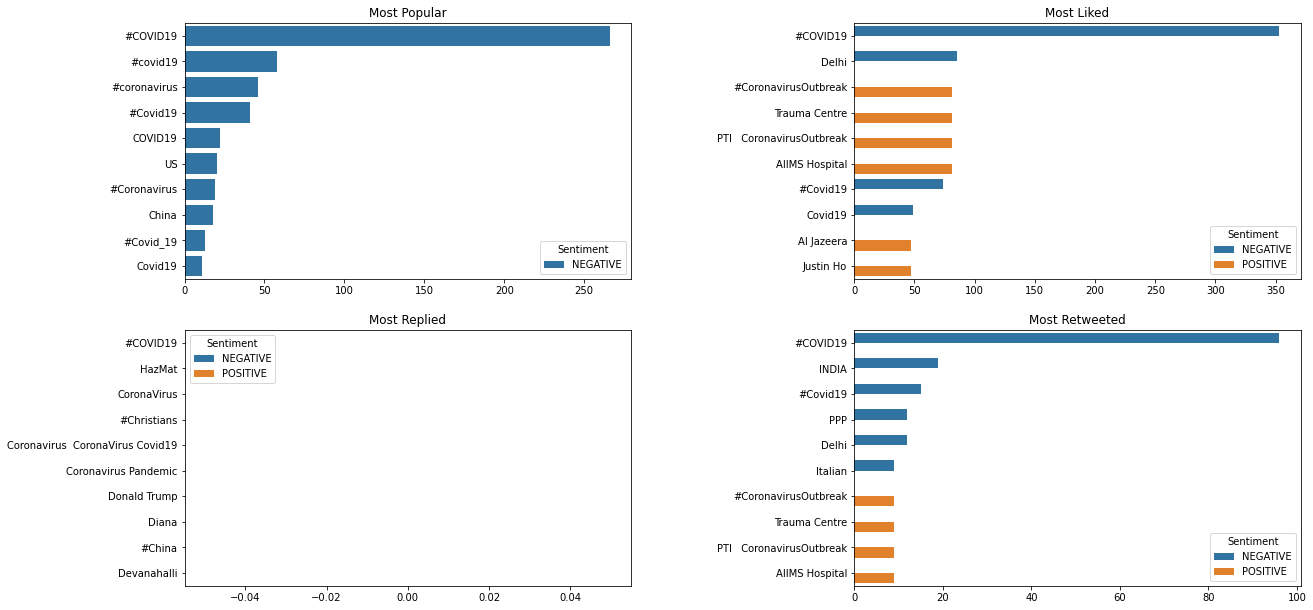

In [38]:
#@title Visualize Top TAGs
Filter_TAG = False #@param {type:"boolean"}
TAG = 'Hashtag' #@param ["Hashtag", "Person", "Location", "Organization"]
#@markdown ###Pick how many tags to display per chart:
Top_N = 10 #@param {type:"integer"}

# get TAG value
if TAG != 'Hashtag':
  TAG = TAG[:3].upper()

if Filter_TAG:
  filtered_group = ner_groups[(ner_groups['tag_type'] == TAG)]
else:
  filtered_group = ner_groups

# plot the figures
fig = plt.figure(figsize=(20, 16))
fig.subplots_adjust(hspace=0.2, wspace=0.5)

ax1 = fig.add_subplot(321)
sns.barplot(x="Frequency", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax2 = fig.add_subplot(322)
filtered_group = filtered_group.sort_values(['Total_Likes'], ascending=False)
sns.barplot(x="Total_Likes", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax3 = fig.add_subplot(323)
filtered_group = filtered_group.sort_values(['Total_Replies'], ascending=False)
sns.barplot(x="Total_Replies", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax4 = fig.add_subplot(324)
filtered_group = filtered_group.sort_values(['Total_Retweets'], ascending=False)
sns.barplot(x="Total_Retweets", y="tag", data=filtered_group[:Top_N], hue="Sentiment")

ax1.title.set_text('Most Popular')
ax2.title.set_text('Most Liked')
ax3.title.set_text('Most Replied')
ax4.title.set_text('Most Retweeted')

ax1.set_ylabel('')    
ax1.set_xlabel('')
ax2.set_ylabel('')    
ax2.set_xlabel('')
ax3.set_ylabel('')    
ax3.set_xlabel('')
ax4.set_ylabel('')    
ax4.set_xlabel('')

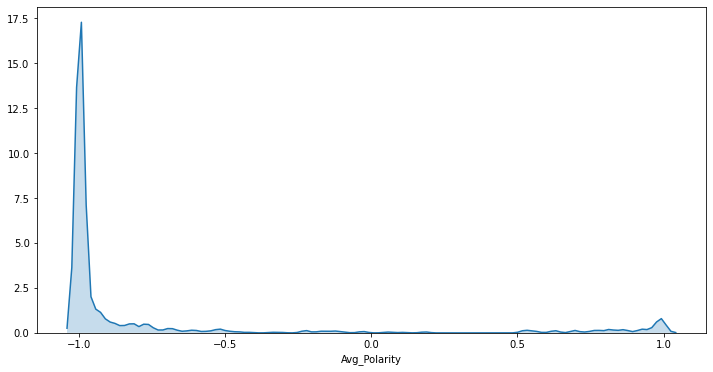

In [39]:
fig = plt.figure(figsize=(12, 6))
sns.distplot(filtered_group['Avg_Polarity'], hist=False, kde_kws={"shade": True})

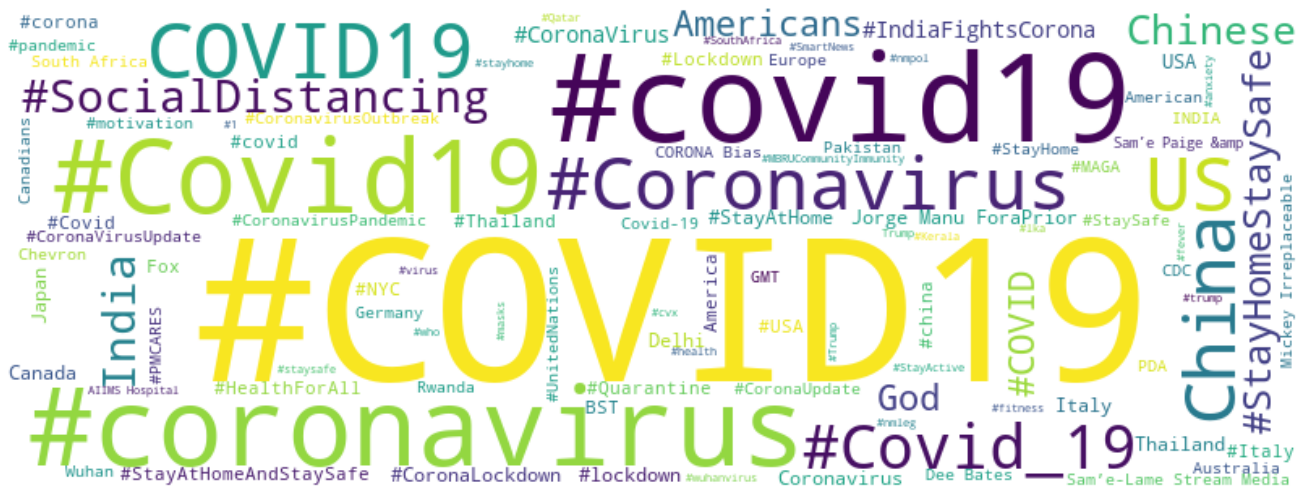

In [42]:
#@title Build Word Cloud For Top TAGs
Metric = 'Most Popular' #@param ["Most Popular", "Most Liked", "Most Replied", "Most Retweeted"]
#@markdown
Filter_TAG = False #@param {type:"boolean"}
##@markdown
TAG = 'Hashtag' #@param ["Hashtag", "Person", "Location", "Organization"]


# get correct Metric value
if Metric == 'Most Popular':
   Metric = 'Frequency'
elif Metric == 'Most Liked':
   Metric = 'Total_Likes'
elif Metric == 'Most Replied':
   Metric = 'Total_Replies'
elif Metric == 'Most Retweeted':
   Metric = 'Total_Retweets'    

# get TAG value
if TAG != 'Hashtag':
  TAG = TAG[:3].upper()

if Filter_TAG:
  filtered_group = ner_groups[(ner_groups['tag_type'] == TAG)]
else:
  filtered_group = ner_groups

countDict = {}

for index, row in filtered_group.iterrows():
  if row[Metric] == 0:
    row[Metric] = 1
  countDict.update( {row['tag'] : row[Metric]} )


clear_output()

# Generate Word Cloud
wordcloud = WordCloud(
    max_words=100,
#     max_font_size=50,
    height=300,
    width=800,
    background_color = 'white',
    contour_width=1,
    contour_color='steelblue',
    stopwords = STOPWORDS).generate_from_frequencies(countDict)
fig = plt.figure(
    figsize = (18, 18),
    )
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()